## Objective

This is a demo notebook for the clustering method. The demo use graphs to illustrate the steps for slicing an account's time series into waveforms and calculate the centroids for each cluster that will later be used for reconstruction. The reconstruced values will be used to compare against the original input to calculate the reconstruction error. Finally, the error terms that exceed certain threshold will be identified to be anomaly points.

## System Setup and Input

   1. We require pandas and numpy for dataframe, row, column, and cell manipulation; and we require KMeans from sklearn cluster package to calculated centroids for each chunk of waveforms.
   2. We are using one individual account for demo purpose.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# the main packages for this methods will be pandas, numpy, matplotlib and KMeans from sklearn
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [3]:
# load in the pickle file from output folder after cleaning the original NYCHA dataset
df_prorated_imputed = pd.read_pickle("../output/NYCHA_Prorated_KWH")
df_prorated_imputed.head()

,Building_Meter,Month,Month_Type,Month_#_Days,Prorated_Days,Gap_Days,Gap_Type,Prorated_KWH,Imputed_KWH,NA_KWH
0,165.0 - BLD 04_99273488,2009-12-01,First_Month,31,9.0,0.0,No Gap,19694.117647,67835.294118,False
1,165.0 - BLD 04_99273488,2010-01-01,Month_In_The_Middle,31,31.0,0.0,No Gap,68283.025210,68283.025210,False
2,165.0 - BLD 04_99273488,2010-02-01,Month_In_The_Middle,28,28.0,0.0,No Gap,61071.133005,61071.133005,False
3,165.0 - BLD 04_99273488,2010-03-01,Month_In_The_Middle,31,31.0,0.0,No Gap,58011.118077,58011.118077,False
4,165.0 - BLD 04_99273488,2010-04-01,Month_In_The_Middle,30,30.0,0.0,No Gap,55164.054336,55164.054336,False


In [4]:
# for this demo, we will be using Account 165.0 - BLD 03_90327795
# we are resetting the index since this is not the first account in the dataframe
df_one_building = df_prorated_imputed[df_prorated_imputed['Building_Meter']=='165.0 - BLD 03_90327795']
df_one_building = df_one_building.reset_index()

## User Defined Functions for Demo

We defined three UDFs for demo purpose, **sliding_chunker** is used to slice the time series data by window_len and slide_len; **plot_waves** is defined to plot waveforms for illustrations of the results; **reconstruct** is used to find centroids and average centroids for each cluster.

In [5]:
def sliding_chunker(data, window_len, slide_len):
    """
    Split a list into a series of sub-lists, each sub-list window_len long,
    sliding along by slide_len each time. If the list doesn't have enough
    elements for the final sub-list to be window_len long, the remaining data
    will be dropped.
    e.g. sliding_chunker(range(6), window_len=3, slide_len=2)
    gives [ [0, 1, 2], [2, 3, 4] ]
    """
    chunks = []
    for pos in range(0, len(data), slide_len):
        chunk = np.copy(data[pos:pos+window_len])
        if len(chunk) != window_len:
            continue
        chunks.append(chunk)

    return chunks

In [6]:
def plot_waves(waves, step):
    """
    Plot a set of 9 waves from the given set, starting from the first one
    and increasing in index by 'step' for each subsequent graph
    """
    plt.figure()
    n_graph_rows = 3
    n_graph_cols = 3
    graph_n = 1
    wave_n = 0
    for _ in range(n_graph_rows):
        for _ in range(n_graph_cols):
            axes = plt.subplot(n_graph_rows, n_graph_cols, graph_n)
            axes.set_ylim([min(df_one_building['Imputed_KWH'])-10000, max(df_one_building['Imputed_KWH'])+10000])
            plt.plot(waves[wave_n])
            graph_n += 1
            wave_n += step
    # fix subplot sizes so that everything fits
    plt.suptitle('Waveform Segments of 8 data points')
    plt.tight_layout(pad=2,h_pad=1)
    plt.show()

In [7]:
def reconstruct(data, window, clusterer):
    """
    Reconstruct the given data using the cluster centers from the given
    clusterer.
    """
    window_len = len(window)
    slide_len = window_len/2
    segments = sliding_chunker(data, window_len, slide_len)
    reconstructed_data = np.zeros(len(data))
    for segment_n, segment in enumerate(segments):
        # window the segment so that we can find it in our clusters which were
        # formed from windowed data
        segment *= window
        nearest_match_idx = clusterer.predict(segment)[0]
        nearest_match = np.copy(clusterer.cluster_centers_[nearest_match_idx])

        pos = segment_n * slide_len
        reconstructed_data[pos:pos+window_len] += nearest_match

    return reconstructed_data

## Demo

For the given account, we are slicing the time series data by segment length of 8 data points and a sliding window of 1 step at a time.

In [8]:
segment_len = 8
slide_len = 1

segments = []
for start_pos in range(0, len(df_one_building['Imputed_KWH']), slide_len):
    end_pos = start_pos + segment_len
    # make a copy so changes to 'segments' doesn't modify the original data
    segment = np.copy(df_one_building['Imputed_KWH'][start_pos:end_pos])
    # if we're at the end and we've got a truncated segment, drop it
    if len(segment) != segment_len:
        continue
    segments.append(segment)

print("Produced %d waveform segments" % len(segments))

Produced 96 waveform segments


Below are 9 example segments of the from the demo account.

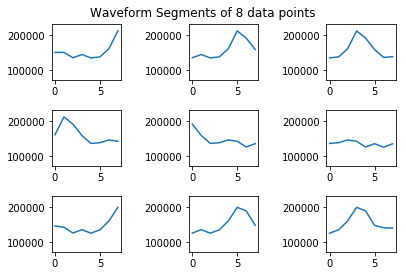

In [9]:
plot_waves(segments, step=2)

We use KMeans to cluster these 96 segments into 12 clusters. The number of clusters are determined by elbow methods and accounted for the fact we want to capture the waveform of all 12 months.

In [10]:
clusterer = KMeans(n_clusters=12)
clusterer.fit(segments)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Below are 9 examples waveforms of cluster centers.

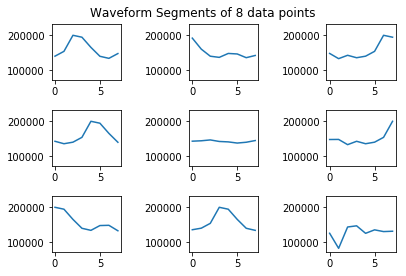

In [11]:
plot_waves(clusterer.cluster_centers_, step=1)

In [12]:
slide_len = 1
test_segments = sliding_chunker(
    df_one_building['Imputed_KWH'],
    window_len=segment_len,
    slide_len=slide_len
)

We cherry pick index 16 and compare the original segment with the nearest centroid segment.

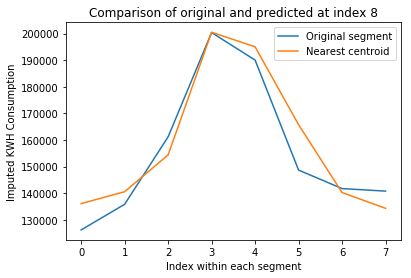

In [13]:
centroids = clusterer.cluster_centers_

segment = np.copy(test_segments[16])
# predict() returns a list of centres to cope with the possibility of multiple
# samples being passed
nearest_centroid_idx = clusterer.predict(test_segments[16].reshape(1,-1))[0]
nearest_centroid = np.copy(centroids[nearest_centroid_idx])
plt.figure()
plt.plot(segment, label="Original segment");
plt.plot(nearest_centroid, label="Nearest centroid");
plt.title('Comparison of original and predicted at index 8');
plt.xlabel('Index within each segment');
plt.ylabel('Imputed KWH Consumption');
plt.legend();
plt.show();

We recontruct the data using nearest centroids for each data points and connect all nearest centroids to compare to original data.

Maximum reconstruction error was 40168.1
99th percentile of reconstruction error was 23328.9


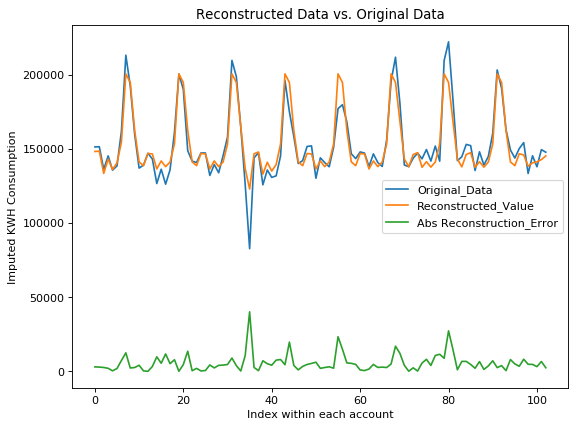

In [14]:
data = df_one_building['Imputed_KWH']
reconstruction = np.zeros(len(data))


for segment_n, segment in enumerate(test_segments):
    # don't modify the data in segments
    segment = np.copy(segment)
    nearest_centroid_idx = clusterer.predict(segment.reshape(1,-1))[0]
    centroids = clusterer.cluster_centers_
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])
    
    # overlay our reconstructed segments with an overlap of half a segment
    pos = int(segment_n * slide_len)
    reconstruction[pos:pos+segment_len] += nearest_centroid/(segment_len/slide_len)

# fix first segment_len and last segment_len data points since they are not modeled segment_len/slide_len times
for i in np.linspace(0,segment_len-1,segment_len).astype(int):
    reconstruction[i] = reconstruction[i]/(i+1)*(segment_len/slide_len)
    reconstruction[-i -1 ] = reconstruction[-i - 1]/(i+1)*(segment_len/slide_len)

n_plot_samples = len(data)
error = reconstruction[0:n_plot_samples] - data[0:n_plot_samples]
error_99th_percentile = np.percentile(error, 99)
print("Maximum reconstruction error was %.1f" % error.max())
print("99th percentile of reconstruction error was %.1f" % error_99th_percentile)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(data[0:n_plot_samples], label="Original_Data")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed_Value")
plt.plot(np.abs(error[0:n_plot_samples]), label="Abs Reconstruction_Error")
plt.title('Reconstructed Data vs. Original Data');
plt.xlabel('Index within each account');
plt.ylabel('Imputed KWH Consumption');
plt.legend();
plt.show();

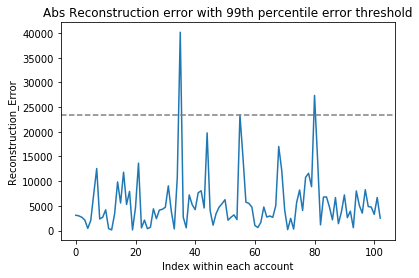

In [15]:
plt.plot(np.abs(error[0:n_plot_samples]), label="Reconstruction Error")
plt.axhline(y=error_99th_percentile,linestyle='--',color='gray');
plt.title('Abs Reconstruction error with 99th percentile error threshold');
plt.xlabel('Index within each account');
plt.ylabel('Reconstruction_Error');
plt.show();

Anomaly points are detected by evaluating the recontruction error between original data and recontructed data. Based on domain expert suggestion, we are using 99th percentile of reconstruction error to define anomolous points.

We will enrich the original dataframe for each account by adding whether they are anomolous or not, the reconstruction error and the predicted reconstructed value.

In [17]:
df_one_building['Anomaly'] = np.where(np.abs(error[0:n_plot_samples])>error_99th_percentile, 'Yes', 'No')

In [18]:
output = df_one_building[['Building_Meter','Month','Month_Type','Imputed_KWH','Anomaly']]

In [19]:
output['Reconstruction_Error'] = error
output['Reconstructed_Value'] = reconstruction

/Users/crystal-pro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/crystal-pro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
output[['Building_Meter','Month','Imputed_KWH','Reconstructed_Value','Reconstruction_Error','Anomaly']]

,Building_Meter,Month,Imputed_KWH,Reconstructed_Value,Reconstruction_Error,Anomaly
0,165.0 - BLD 03_90327795,2009-12-01,151280.000000,148186.082455,-3093.917545,No
1,165.0 - BLD 03_90327795,2010-01-01,151382.857143,148413.088978,-2969.768165,No
2,165.0 - BLD 03_90327795,2010-02-01,136106.798030,133417.583106,-2689.214923,No
3,165.0 - BLD 03_90327795,2010-03-01,145210.950888,143069.978897,-2140.971991,No
4,165.0 - BLD 03_90327795,2010-04-01,135622.152560,136059.118767,436.966207,No
5,165.0 - BLD 03_90327795,2010-05-01,138498.574713,140519.003325,2020.428612,No
6,165.0 - BLD 03_90327795,2010-06-01,161783.666667,154383.070780,-7400.595887,No
7,165.0 - BLD 03_90327795,2010-07-01,213036.379310,200475.197876,-12561.181434,No
8,165.0 - BLD 03_90327795,2010-08-01,192317.330367,194666.578504,2349.248137,No
9,165.0 - BLD 03_90327795,2010-09-01,159626.475508,162308.432503,2681.956995,No
